### *Libraries*

In [58]:
import numpy as np
import matplotlib.pylab as plt
import sympy as sp
import pandas as pd
from scipy.signal import savgol_filter

## **Multilayer Code**

In [59]:
def SNELL(theta_1,N_):
  THETA = np.array( np.zeros( (np.shape(N_)[0],np.shape(N_)[1]) ), dtype=complex )
  THETA[0,:] = np.array([theta_1]*np.shape(N_)[1])

  for i in range(np.shape(N_)[0] - 1):
      THETA[i + 1,:] = ( np.arcsin( ( np.sin(THETA[i,:]) * N_[i,:]) / N_[i + 1,:]) )
  return THETA[:,:]

def PATH(GROSOR_,THETA_):
  CAMINO = GROSOR_[:,:] / np.cos(THETA_[1:-1,:])
  return np.array(CAMINO)

In [60]:
def TE(ij_,THETA_,N_):

  if  ij_ != "12" and ij_ != "21":
    raise Exception("sub_index not valid")

  R_TE, T_TE = np.zeros( ( np.shape(N_)[0] - 1, np.shape(N_)[1] ), dtype=complex ), np.zeros( ( np.shape(N_)[0] - 1, np.shape(N_)[1] ), dtype=complex )

  if ij_ == '12':
    for i in range(np.shape(N_)[0] - 1):
      R_TE[i,:] = ( ( N_[i,:] * np.cos(THETA_[i,:]) ) - (N_[i + 1,:] * np.cos(THETA_[i + 1,:]) ) ) / ( ( N_[i,:] * np.cos(THETA_[i,:]) ) + ( N_[i + 1,:] * np.cos(THETA_[i + 1,:]) ) )
      T_TE[i,:] = 1 + R_TE[i,:]

  if ij_ == '21':
    for i in range(np.shape(N_)[0] - 1):
      R_TE[i,:] = ( ( N_[i + 1,:] * np.cos(THETA_[i + 1,:]) ) - (N_[i,:] * np.cos(THETA_[i,:]) ) ) / ( ( N_[i + 1,:] * np.cos(THETA_[i + 1,:]) ) + ( N_[i,:] * np.cos(THETA_[i,:]) ) )
      T_TE[i,:] = 1 + R_TE[i,:]

  return np.array( ( T_TE, R_TE ) )

def TM(ij_,THETA_,N_):

  if  ij_ != "12" and ij_ != "21":
    raise Exception("sub_index not valid")

  R_TM, T_TM = np.zeros( ( np.shape(N_)[0] - 1, np.shape(N_)[1] ), dtype=complex ), np.zeros( ( np.shape(N_)[0] - 1, np.shape(N_)[1] ), dtype=complex )

  if ij_ == '12':
    for i in range(np.shape(N_)[0] - 1):
      R_TM[i,:] = ( ( N_[i,:] * (np.cos(THETA_[i,:])**(-1)) ) - ( N_[i + 1,:] * (np.cos(THETA_[i + 1,:])**(-1)) ) ) / ( ( N_[i,:] * (np.cos(THETA_[i,:])**(-1)) ) + ( N_[i + 1,:] * (np.cos(THETA_[i + 1,:])**(-1)) ) )
      T_TM[i,:] = ( (1 + R_TM[i,:]) * np.cos(THETA_[i]) ) / np.cos(THETA_[i + 1])

  if ij_ == '21':
    for i in range(np.shape(N_)[0] - 1):
      R_TM[i,:] = ( ( N_[i + 1,:] * (np.cos(THETA_[i + 1,:])**(-1)) ) - ( N_[i,:] * (np.cos(THETA_[i,:])**(-1)) ) ) / ( ( N_[i + 1,:] * (np.cos(THETA_[i + 1,:])**(-1)) ) + ( N_[i,:] * (np.cos(THETA_[i,:])**(-1)) ) )
      T_TM[i,:] = ( (1 + R_TM[i,:]) * np.cos(THETA_[i + 1]) ) / np.cos(THETA_[i])

  return np.array( ( T_TM, R_TM ) )

In [61]:
def S_matrix(p_,THETA_, N_):

  if  p_ != "TE" and p_ != "TM":
    raise Exception("polarization not valid")

  TE_12_, TM_12_ = TE('12',THETA_, N_), TM('12',THETA_, N_)
  TE_21_, TM_21_ = TE('21',THETA_, N_), TM('21',THETA_, N_)
  S_TE, S_TM = np.zeros( ( np.shape(TE_12_)[2],np.shape(TE_12_)[1],2,2 ), dtype=complex ) , np.zeros( ( np.shape(TM_12_)[2],np.shape(TM_12_)[1],2,2 ), dtype=complex )

  if p_ == "TE":
    S_TE[:,:,:,0], S_TE[:,:,:,1] = TE_12_.T[:,:,:], TE_21_.T[:,:,::-1]
    S = S_TE

  if p_ == "TM":
    S_TM[:,:,:,0], S_TM[:,:,:,1] = TM_12_.T[:,:,:], TM_21_.T[:,:,::-1]
    S = S_TM

  return S

def P_matrix(CAMINO_, ESPECTRO_, N_):
  K_0 = ( 2*np.pi ) / ESPECTRO_
  K_ = np.zeros ( np.shape(CAMINO_), dtype=complex )

  for i in range(np.shape(CAMINO_)[0]):
    K_[i,:] = K_0[:] * N_[i + 1,:]

  P_ = np.zeros( ( np.shape(CAMINO_)[1],np.shape(CAMINO_)[0],2,2 ), dtype=complex )
  P_[:,:,0,0] = np.exp(-1j * ( K_[:,:].T * CAMINO_[:,:].T ) )
  P_[:,:,1,1] = np.exp(1j * ( K_[:,:].T * CAMINO_[:,:].T ) )

  return P_

In [62]:
def StoM_matrix(S_):

    M_ = np.zeros( np.shape(S_), dtype=complex )

    M_[:,:,0,0] = ( S_[:,:,0,0]*S_[:,:,1,1] - S_[:,:,0,1]*S_[:,:,1,0] ) * ( (S_[:,:,1,1])**(-1) )
    M_[:,:,1,0] = ( -S_[:,:,1,0] ) * ( (S_[:,:,1,1])**(-1) )
    M_[:,:,0,1] = ( S_[:,:,0,1] ) * ( (S_[:,:,1,1])**(-1) )
    M_[:,:,1,1] = ( (S_[:,:,1,1])**(-1) )

    return M_

def MMtoSS_matrix(MM_):

    SS_ = np.zeros( np.shape(MM_), dtype=complex )

    SS_[:,0,0] = ( MM_[:,0,0]*MM_[:,1,1] - MM_[:,0,1]*MM_[:,1,0] ) / ( (MM_[:,1,1]) )
    SS_[:,1,0] = ( -MM_[:,1,0] ) / ( (MM_[:,1,1]) )
    SS_[:,0,1] = ( MM_[:,0,1] ) / ( (MM_[:,1,1]) )
    SS_[:,1,1] = 1 / ( (MM_[:,1,1]) )

    return SS_

In [63]:
def multilayer_film(theta_1, p_, ESPECTRO_, GROSOR_, N_):

    if theta_1 >= ( np.pi / 2 ) or theta_1 < 0:
        raise Exception("angle not valid")

    THETA_ = SNELL(theta_1,N_)
    CAMINO_ = PATH(GROSOR_,THETA_)

    S_ = S_matrix(p_,THETA_, N_)
    P_ = P_matrix(CAMINO_, ESPECTRO_, N_)
    M_ = StoM_matrix(S_)

    MM_ = np.zeros( (np.shape(M_)[0],np.shape(M_)[2],np.shape(M_)[3]), dtype=complex )

    for i in range(np.shape(MM_)[0]):
        MM_[i,:,:] = np.identity(2, dtype=complex )

    for l in range(np.shape(P_)[1]):
        MM_ = MM_ @ M_[:,-(1+l),:,:] @ P_[:,-(1+l),:,:]
    MM_ = MM_ @ M_[:,0,:,:]

    SS_ = MMtoSS_matrix(MM_)

    return SS_

## **Data Pocessing**

### *Data processing Functions*

In [64]:
def re_escalamiento(R_, R_M):
    k_ = ( np.max(R_) - np.min(R_) ) / ( np.max(R_M) - np.min(R_M) )
    return k_

def fit(R_, R_M):
    fit = np.sum( np.abs(R_[:] - R_M[:]) ) / np.shape(R_)[0]
    return fit

### *Experimental Data Importing*

In [65]:
#@title Data Pocessing 

Si_ = pd.read_csv("/home/els4nchez/Pictures/test/Personal-projects/Multilayer Spectra Analysis /Simulation/Si.txt"
                  , delimiter='\t')
SiO2_ = pd.read_csv("/home/els4nchez/Pictures/test/Personal-projects/Multilayer Spectra Analysis /Simulation/SiO2.txt", delimiter='\t')

MEDIDAS_EXPERIMENTALES = pd.read_excel("/home/els4nchez/Pictures/test/Personal-projects/Multilayer Spectra Analysis /Simulation/Medidas.xls")

ESPECTRO_ = np.array(MEDIDAS_EXPERIMENTALES["Wavelength [nm]"])
theta_1, p_ = 0, "TM"


### *Refraction Index Plotting*

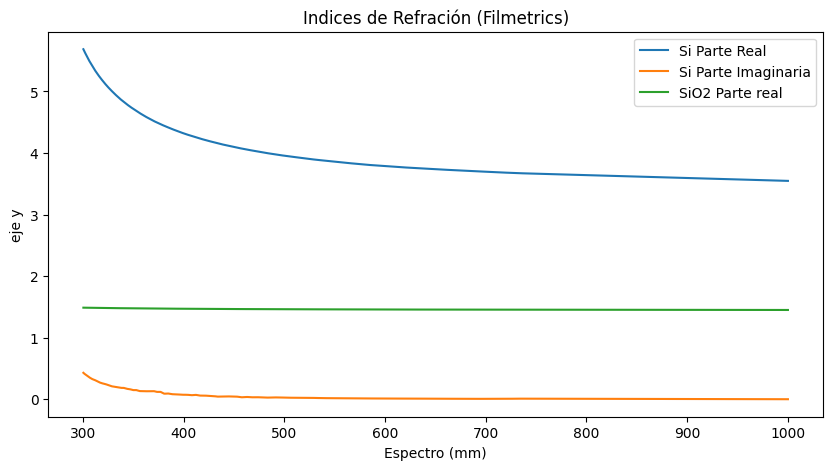

In [66]:
plt.figure(figsize = (10,5))
plt.title("Indices de Refración (Filmetrics)")
plt.plot(ESPECTRO_, N2_R_, label = "Si Parte Real")
plt.plot(ESPECTRO_, N2_I_, label = "Si Parte Imaginaria")
plt.plot(ESPECTRO_, abs(N1_), label = "SiO2 Parte real")
plt.xlabel("Espectro (mm)")
plt.ylabel("eje y")
plt.legend()
#plt.xlim(400,1000)
# plt.ylim(0.75,1.05)
plt.show()

### *Experimental Data Plotting*

#### Raw Experimental Data 

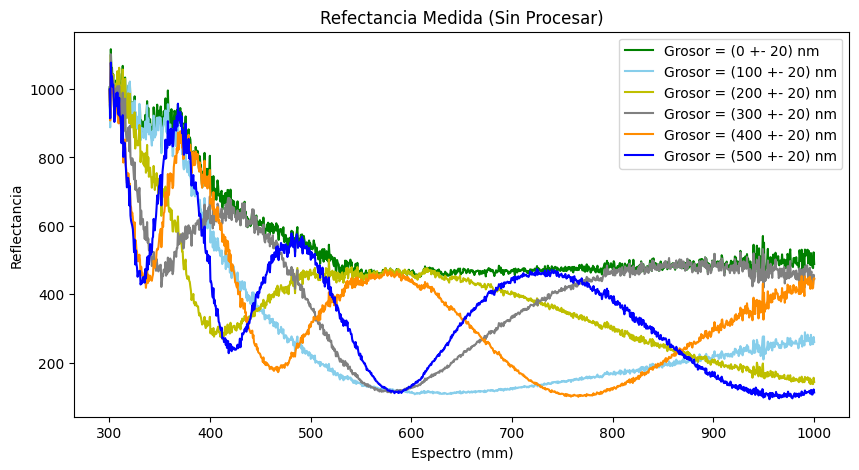

In [67]:
R1_M = np.array(MEDIDAS_EXPERIMENTALES["#1"])
R2_M = np.array(MEDIDAS_EXPERIMENTALES["#2"])
R3_M = np.array(MEDIDAS_EXPERIMENTALES["#3"])
R4_M = np.array(MEDIDAS_EXPERIMENTALES["#4"])
R5_M = np.array(MEDIDAS_EXPERIMENTALES["#5"])
R6_M = np.array(MEDIDAS_EXPERIMENTALES["#6"])

plt.figure(figsize = (10,5))
plt.title("Refectancia Medida (Sin Procesar)")
plt.plot(ESPECTRO_, R6_M , 'g', label = "Grosor = (0 +- 20) nm")
plt.plot(ESPECTRO_, R5_M , 'skyblue' , label = "Grosor = (100 +- 20) nm")
plt.plot(ESPECTRO_, R4_M , 'y', label = "Grosor = (200 +- 20) nm")
plt.plot(ESPECTRO_, R3_M , 'grey', label = "Grosor = (300 +- 20) nm")
plt.plot(ESPECTRO_, R2_M , 'darkorange', label = "Grosor = (400 +- 20) nm")
plt.plot(ESPECTRO_, R1_M , 'b', label = "Grosor = (500 +- 20) nm")
plt.xlabel("Espectro (mm)")
plt.ylabel("Reflectancia")
plt.legend()
# plt.xlim(400,1000)
# plt.ylim(0,0.2)
plt.show()

#### Smoothed Experimental Data 

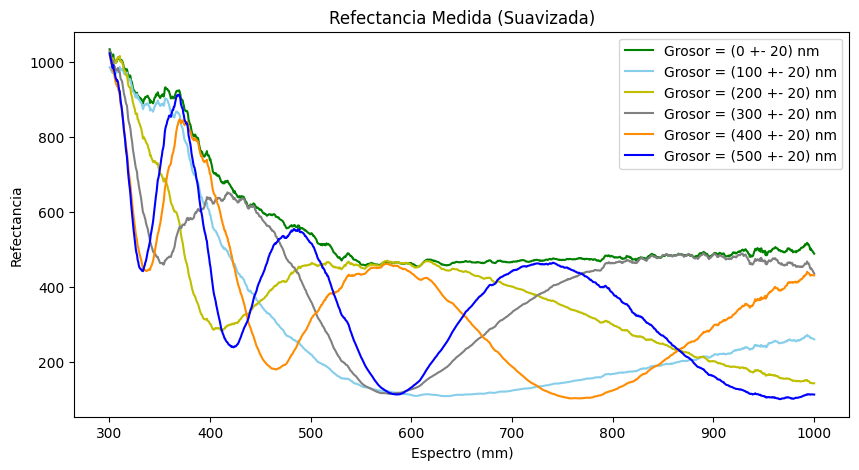

In [68]:
le, py = 10, 1
SR1_ = savgol_filter(R1_M, window_length=le, polyorder=py)
SR2_ = savgol_filter(R2_M, window_length=le, polyorder=py)
SR3_ = savgol_filter(R3_M, window_length=le, polyorder=py)
SR4_ = savgol_filter(R4_M, window_length=le, polyorder=py)
SR5_ = savgol_filter(R5_M, window_length=le, polyorder=py)
SR6_ = savgol_filter(R6_M, window_length=le, polyorder=py)

plt.figure(figsize = (10,5))
plt.title("Refectancia Medida (Suavizada)")
plt.plot(ESPECTRO_, SR6_ , 'g', label = "Grosor = (0 +- 20) nm")
plt.plot(ESPECTRO_, SR5_ , 'skyblue' , label = "Grosor = (100 +- 20) nm")
plt.plot(ESPECTRO_, SR4_ , 'y', label = "Grosor = (200 +- 20) nm")
plt.plot(ESPECTRO_, SR3_ , 'grey', label = "Grosor = (300 +- 20) nm")
plt.plot(ESPECTRO_, SR2_ , 'darkorange', label = "Grosor = (400 +- 20) nm")
plt.plot(ESPECTRO_, SR1_ , 'b', label = "Grosor = (500 +- 20) nm")
plt.xlabel("Espectro (mm)")
plt.ylabel("Refectancia")
plt.legend()
# plt.xlim(400,1000)
# plt.ylim(0,0.2)
plt.show()

## **Simulated Plotting**

### *Manufacturer Parameters*

In [75]:
G_6 = -20.0
G_5 = 95.51020408163265
G_4 = 220.0
G_3 = 294.6938775510204
G_2 = 382.44897959183675
G_1 = 505.3061224489796

### *Simulated Reflectance*

In [70]:
c = -96.26530612244898 
k = 0
z = 0
ki = 0

#g6, g5, g4, g3, g2, g1 = 0, 100, 200, 300, 400, 500
g6, g5, g4, g3, g2, g1 = 0, G_5, G_4, G_3, G_2, G_1

ESPECTRO_Si_, N_Si_, K_Si_ = np.array(Si_["Wavelength(nm)"]), np.array(Si_["n"]), np.array(Si_["k"])
ESPECTRO_SiO2_, N_SiO2_ = np.array(SiO2_["Wavelength(nm)"]), np.array(SiO2_["n"])

N0_ = np.ones( np.shape(ESPECTRO_)[0], dtype = complex  )

N1_ = np.zeros( np.shape(ESPECTRO_)[0], dtype = complex  )
N1_[:] = np.interp(ESPECTRO_, ESPECTRO_SiO2_, N_SiO2_)[:] + z

N2_ = np.zeros( np.shape(ESPECTRO_)[0], dtype = complex )
N2_R_ = np.interp(ESPECTRO_, ESPECTRO_Si_ + c, N_Si_)[:] + k
N2_I_ = np.interp(ESPECTRO_, ESPECTRO_Si_ + c, K_Si_)[:] + ki
N2_[:] = N2_R_[:] + N2_I_[:]

N_ = np.array( (N0_, N1_, N2_) )

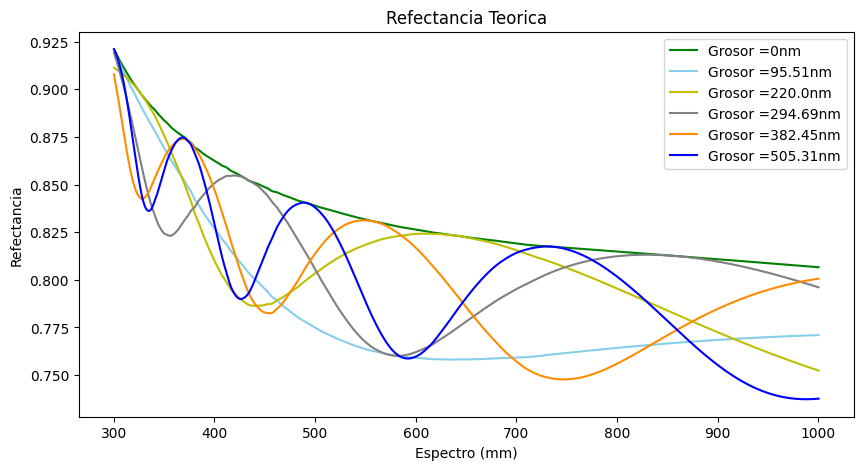

In [71]:
R6_ = 1 - (np.abs(multilayer_film(theta_1, p_, ESPECTRO_, np.matrix( ( [g6] ) ), N_)[:,0,0]))**2
R5_ = 1 - (np.abs(multilayer_film(theta_1, p_, ESPECTRO_, np.matrix( ( [g5] ) ), N_)[:,0,0]))**2
R4_ = 1 - (np.abs(multilayer_film(theta_1, p_, ESPECTRO_, np.matrix( ( [g4] ) ), N_)[:,0,0]))**2
R3_ = 1 - (np.abs(multilayer_film(theta_1, p_, ESPECTRO_, np.matrix( ( [g3] ) ), N_)[:,0,0]))**2
R2_ = 1 - (np.abs(multilayer_film(theta_1, p_, ESPECTRO_, np.matrix( ( [g2] ) ), N_)[:,0,0]))**2
R1_ = 1 - (np.abs(multilayer_film(theta_1, p_, ESPECTRO_, np.matrix( ( [g1] ) ), N_)[:,0,0]))**2

plt.figure(figsize = (10,5))
plt.title("Refectancia Teorica")
plt.plot(ESPECTRO_, R6_ , 'g', label = "Grosor =" + str(round(g6,2)) + "nm")
plt.plot(ESPECTRO_, R5_ , 'skyblue' , label = "Grosor =" +str(round(g5,2)) + "nm")
plt.plot(ESPECTRO_, R4_ , 'y', label = "Grosor =" + str(round(g4,2)) + "nm")
plt.plot(ESPECTRO_, R3_ , 'grey', label = "Grosor =" + str(round(g3,2)) + "nm")
plt.plot(ESPECTRO_, R2_ , 'darkorange', label = "Grosor =" + str(round(g2,2)) + "nm")
plt.plot(ESPECTRO_, R1_ , 'b', label = "Grosor =" + str(round(g1,2)) + "nm")
plt.xlabel("Espectro (mm)")
plt.ylabel("Refectancia")
plt.legend()
# plt.xlim(500,1000)
# plt.ylim(0.75,1.05)
plt.show()

### *Experimental Data Rescaling*

In [72]:
k_ = ( re_escalamiento(R1_, SR1_) + re_escalamiento(R2_, SR2_) + re_escalamiento(R3_, SR3_) + re_escalamiento(R4_, SR4_) + re_escalamiento(R5_, SR5_) + re_escalamiento(R6_, SR6_) ) / 6
SU_k_ = ( re_escalamiento(R1_, R1_M) + re_escalamiento(R2_, R2_M) + re_escalamiento(R3_, R3_M) + re_escalamiento(R4_, R4_M) + re_escalamiento(R5_, R5_M) + re_escalamiento(R6_, R6_M) ) / 6

ER6_ = (SR6_ - np.max(SR6_)) * k_ + np.max(R6_)
ER5_ = (SR5_ - np.max(SR6_)) * k_ + np.max(R5_)
ER4_ = (SR4_ - np.max(SR6_)) * k_ + np.max(R4_)
ER3_ = (SR3_ - np.max(SR6_)) * k_ + np.max(R3_)
ER2_ = (SR2_ - np.max(SR6_)) * k_ + np.max(R2_)
ER1_ = (SR1_ - np.max(SR6_)) * k_ + np.max(R1_)

SU_ER6_ = (R6_M - np.max(R6_M)) * SU_k_ + np.max(R6_)
SU_ER5_ = (R5_M - np.max(R6_M)) * SU_k_ + np.max(R5_)
SU_ER4_ = (R4_M - np.max(R6_M)) * SU_k_ + np.max(R4_)
SU_ER3_ = (R3_M - np.max(R6_M)) * SU_k_ + np.max(R3_)
SU_ER2_ = (R2_M - np.max(R6_M)) * SU_k_ + np.max(R2_)
SU_ER1_ = (R1_M - np.max(R6_M)) * SU_k_ + np.max(R1_)


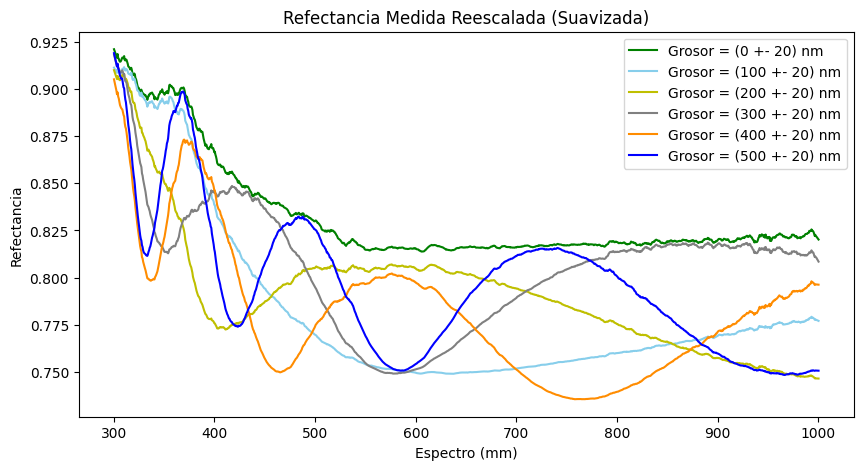

In [73]:
plt.figure(figsize = (10,5))
plt.title("Refectancia Medida Reescalada (Suavizada)")
plt.plot(ESPECTRO_, ER6_ , 'g', label = "Grosor = (0 +- 20) nm")
plt.plot(ESPECTRO_, ER5_ , 'skyblue' , label = "Grosor = (100 +- 20) nm")
plt.plot(ESPECTRO_, ER4_ , 'y', label = "Grosor = (200 +- 20) nm")
plt.plot(ESPECTRO_, ER3_ , 'grey', label = "Grosor = (300 +- 20) nm")
plt.plot(ESPECTRO_, ER2_ , 'darkorange', label = "Grosor = (400 +- 20) nm")
plt.plot(ESPECTRO_, ER1_ , 'b', label = "Grosor = (500 +- 20) nm")
plt.xlabel("Espectro (mm)")
plt.ylabel("Refectancia")
plt.legend()
# plt.xlim(500,1000)
# plt.ylim(0,0.2)
plt.show()

### *Fit Calculus*

In [74]:
fit_6 = fit(R6_, ER6_)
fit_5 = fit(R5_, ER5_)
fit_4 = fit(R4_, ER4_)
fit_3 = fit(R3_, ER3_)
fit_2 = fit(R2_, ER2_)
fit_1 = fit(R1_, ER1_)

FIT_ = np.array([fit_6,fit_5,fit_4,fit_3,fit_2,fit_1])

print("The mean fit is: " + str(np.mean(FIT_)))

The mean fit is: 0.010565338552527406
